In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 17, 'figure.figsize': [15, 7]})

## Net electricity consumption w/o storage prediction from memory

The data we analyze here is the net consumption given by the bare electrical consumption minus the generation difference.

We take the values already calcolated by the envivorment using:

`pd.DataFrame(np.array([env.buildings[i].net_electricity_consumption_without_storage for i in range(5)]).T, columns = [f'Building_{i}' for i in range(1,6)]).to_csv('data/net_electricity_consumption_without_storage.csv', index=False)`

strangly this is a bit too short, but we will check this issue later:

In [2]:
net_consumption_df = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
for i in range (len(net_consumption_df), len(net_consumption_df) + 23):
    net_consumption_df.loc[i] = 0
net_consumption_vec = net_consumption_df.to_numpy().T.flatten()
net_consumption_vec = np.append(np.zeros(23), net_consumption_vec)
net_consumption_24 = np.append(net_consumption_vec, np.zeros(24))
# norm_vec = np.correlate(net_consumption_vec, np.ones(24), mode='same')
norm_24 = np.array([np.sqrt(np.sum(net_consumption_24[i:i+24]**2)) for i in range(len(net_consumption_24)-47)])
np.save('data/net_consumption_24.npy', net_consumption_24)
np.save('data/net_consumption_norm24.npy', norm_24)

net_consumption_df = pd.read_csv(filepath_or_buffer="data/buildings_net_electricity_consumption_without_storage.csv")
for i in range (len(net_consumption_df), len(net_consumption_df) + 3):
    net_consumption_df.loc[i] = 0
net_consumption_vec = net_consumption_df.to_numpy().T.flatten()
net_consumption_vec = np.append(np.zeros(3), net_consumption_vec)
net_consumption_4 = np.append(net_consumption_vec, np.zeros(4))
linear_weights = np.arange(1, 5) / 4
norm_4 = np.array([np.sqrt(np.sum((net_consumption_4[i:i+4] ** 2) * linear_weights)) for i in range(len(net_consumption_4)-7)])
np.save('data/net_consumption_4.npy', net_consumption_4)
np.save('data/net_consumption_norm4.npy', norm_4)

# np.savez('data/net_consumption_vec.npz', data=net_consumption_vec, norm=norm_vec)

Now we have a 1d numpy vector rather than a dataframe, so we can apply dot product to it.

We first define the function that will be used to calculate the dot product, then test it.

In [3]:
def predict_next_24h(input_vec: np.ndarray) -> np.ndarray:
    """
    Predict the next day consumption from the previous 24 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
    """

    assert len(input_vec) == 24, "The input vector must be of length 24"

    input_vec = input_vec / np.sqrt(sum(input_vec ** 2))

    net_consumption = np.load('data/net_consumption_24.npy')
    norm_vec = np.load('data/net_consumption_norm24.npy')

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+24]) for i in range(len(net_consumption)-47)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+24:idx_from_correlation+48]

    return prediction


Random index: 36075


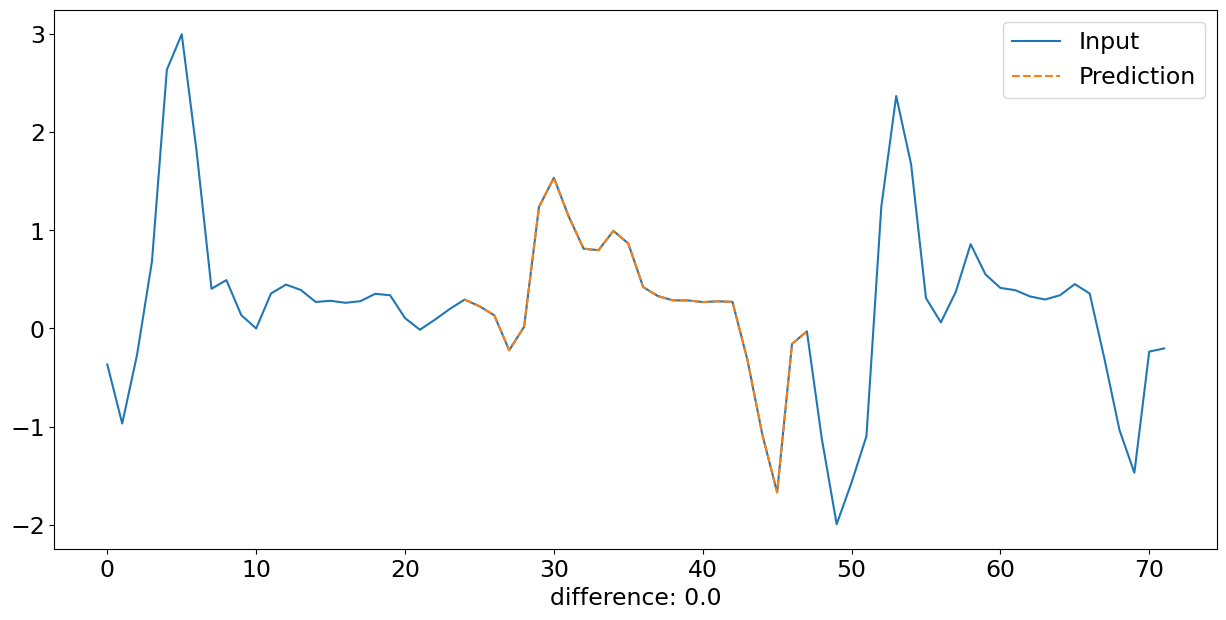

In [4]:
rand_idx = np.random.randint(0, len(net_consumption_vec) - 48)
print(f"Random index: {rand_idx}")
predicted = predict_next_24h(net_consumption_vec[rand_idx:rand_idx + 24])
plt.figure()
plt.plot(net_consumption_vec[rand_idx:rand_idx + 72], label="Input")
plt.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
plt.xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx+24:rand_idx+48]))}")
plt.legend()
plt.show()

This works nice.
Now, let's see how it copes with partial information.

In [43]:
def predict_next_24h_masked(input_vec: np.ndarray, ratio: float) -> np.ndarray:
    """
    Predict the next day consumption from the previous 24 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    assert len(input_vec) == 24, "The input vector must be of length 24"

    input_vec = input_vec / np.sqrt(sum(input_vec ** 2))

    net_consumption = np.load('data/net_consumption_24.npy')
    norm_vec = np.load('data/net_consumption_norm24.npy')

    mask_length = int(len(net_consumption) * ratio)
    net_consumption = net_consumption[:-mask_length]
    norm_vec = norm_vec[:-mask_length]

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+24]) for i in range(len(net_consumption)-47)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+24:idx_from_correlation+48]

    return prediction

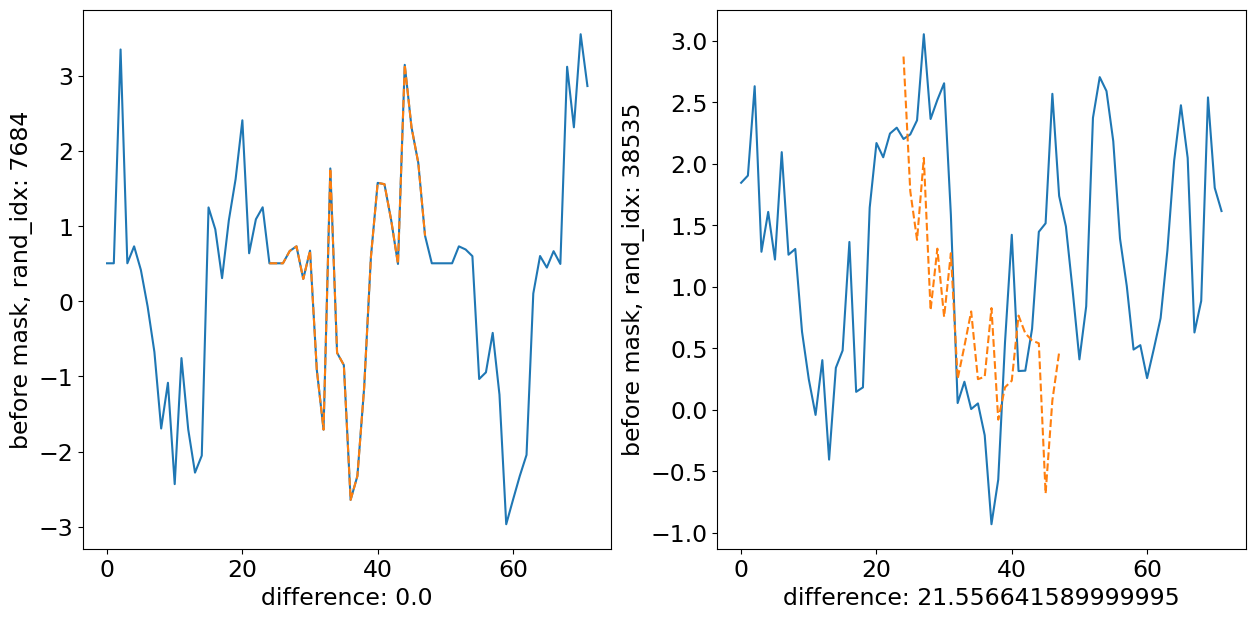

In [44]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_vec) * masking_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2)
rand_idx1 = np.random.randint(0, len(net_consumption_vec) - 48 - mask_len)
predicted = predict_next_24h_masked(net_consumption_vec[rand_idx1:rand_idx1 + 24], masking_ratio)
ax1.plot(net_consumption_vec[rand_idx1:rand_idx1 + 72], label="Input")
ax1.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax1.set_ylabel(f"before mask, rand_idx: {rand_idx1}")
ax1.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx1+24:rand_idx1+48]))}")

rand_idx2 = np.random.randint(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48)
predicted = predict_next_24h_masked(net_consumption_vec[rand_idx2:rand_idx2 + 24], masking_ratio)
ax2.plot(net_consumption_vec[rand_idx2:rand_idx2 + 72], label="Input")
ax2.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax2.set_ylabel(f"before mask, rand_idx: {rand_idx2}")
ax2.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx2+24:rand_idx2+48]))}")

plt.show()

We see that the prediction captures the general trend, but it is not very accurate.

To better the near-future prediction, we use 4 hours predictor, with linear wighting towards the last hour. We then also merge the two predictions with linear weighting.

In [45]:
def predict_next_4h(input_vec: np.ndarray) -> np.ndarray:
    """
    Predict the next 4 hours consumption from the previous 4 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=4
    """
    assert len(input_vec) == 4, "The input vector must be of length 4"

    weights = np.array([0.25, 0.5, 0.75, 1])
    input_vec = input_vec / np.sqrt(sum((input_vec ** 2) * weights))

    net_consumption = np.load('data/net_consumption_4.npy')
    norm_vec = np.load('data/net_consumption_norm4.npy')

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+4] * weights) for i in range(len(net_consumption)-7)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+4:idx_from_correlation+8]

    return prediction

Random index: 4736


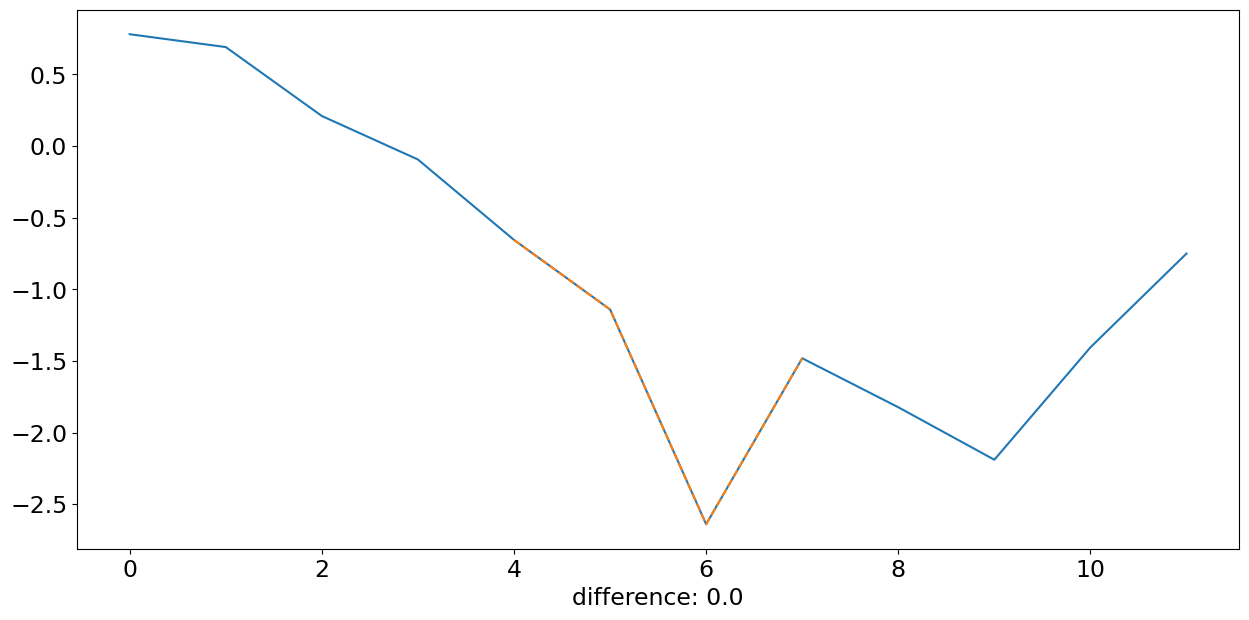

In [46]:
rand_idx = np.random.randint(0, len(net_consumption_vec) - 48)
print(f"Random index: {rand_idx}")
predicted = predict_next_4h(net_consumption_vec[rand_idx:rand_idx + 4])
plt.figure()
plt.plot(net_consumption_vec[rand_idx:rand_idx + 12], label="Input")
plt.plot(np.arange(4, 8), predicted, label="Prediction", linestyle="--")
plt.xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx+4:rand_idx+8]))}")
plt.show()

In [47]:
def predict_next_4h_masked(input_vec: np.ndarray, ratio: float) -> np.ndarray:
    """
    Predict the next 4 hours consumption from the previous 4 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    assert len(input_vec) == 4, "The input vector must be of length 4"

    weights = np.array([0.25, 0.5, 0.75, 1])
    input_vec = input_vec / np.sqrt(sum((input_vec ** 2) * weights))

    net_consumption = np.load('data/net_consumption_4.npy')
    norm_vec = np.load('data/net_consumption_norm4.npy')

    mask_length = int(len(net_consumption) * ratio)
    net_consumption = net_consumption[:-mask_length]
    norm_vec = norm_vec[:-mask_length]

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+4] * weights) for i in range(len(net_consumption)-7)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+4:idx_from_correlation+8]

    return prediction

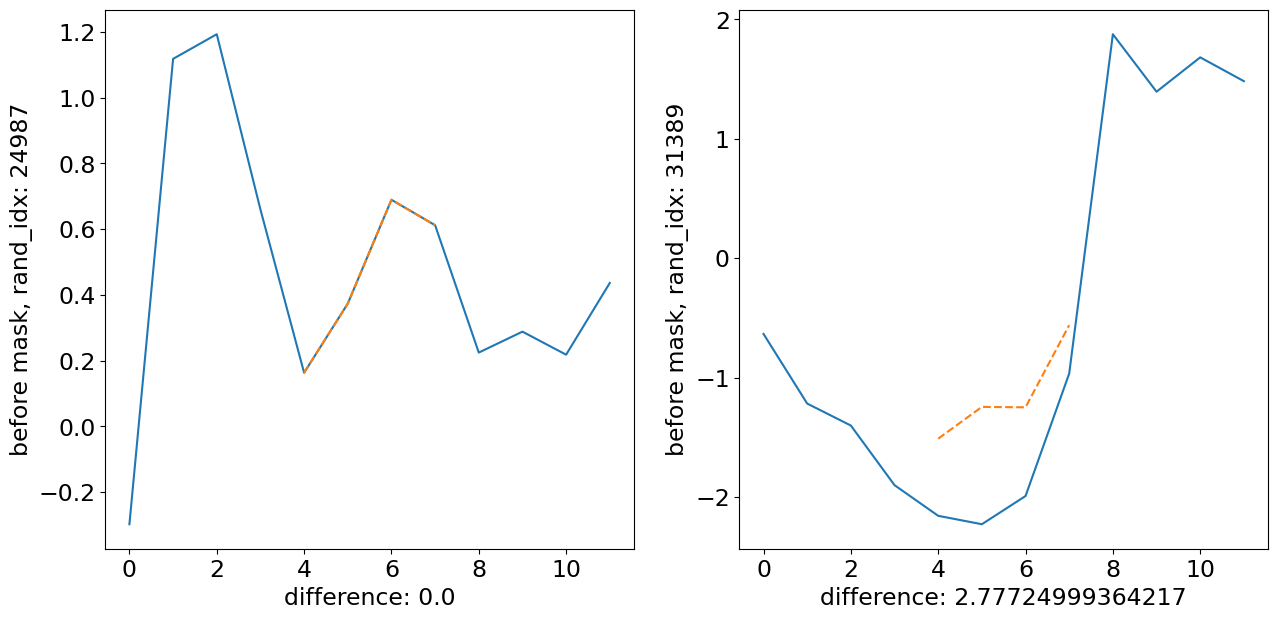

In [48]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_vec) * masking_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2)
rand_idx1 = np.random.randint(0, len(net_consumption_vec) - 48 - mask_len)
predicted = predict_next_4h_masked(net_consumption_vec[rand_idx1:rand_idx1 + 4], masking_ratio)
ax1.plot(net_consumption_vec[rand_idx1:rand_idx1 + 12], label="Input")
ax1.plot(np.arange(4, 8), predicted, label="Prediction", linestyle="--")
ax1.set_ylabel(f"before mask, rand_idx: {rand_idx1}")
ax1.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx1+4:rand_idx1+8]))}")

rand_idx2 = np.random.randint(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48)
predicted = predict_next_4h_masked(net_consumption_vec[rand_idx2:rand_idx2 + 4], masking_ratio)
ax2.plot(net_consumption_vec[rand_idx2:rand_idx2 + 12], label="Input")
ax2.plot(np.arange(4, 8), predicted, label="Prediction", linestyle="--")
ax2.set_ylabel(f"before mask, rand_idx: {rand_idx2}")
ax2.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx2+4:rand_idx2+8]))}")

plt.show()

We see that the short-term prediction is much better than the 24-hour prediction. However, it is still not very accurate.

We will now connect the two predictions with linear weighting.

In [49]:
def predict_next_day_masked(input_vec: np.ndarray, ratio: float) -> np.ndarray:
    """
    Predict the next 4 hours consumption from the previous 4 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    weights = np.append(np.array([0, 0.25, 0.5, 0.75]), np.ones(20))

    prediction_24 = predict_next_24h_masked(input_vec, ratio)
    prediction_4 = np.append(predict_next_4h_masked(input_vec[-4:], ratio), np.zeros(20))

    return prediction_24 * weights + prediction_4 * (1 - weights)


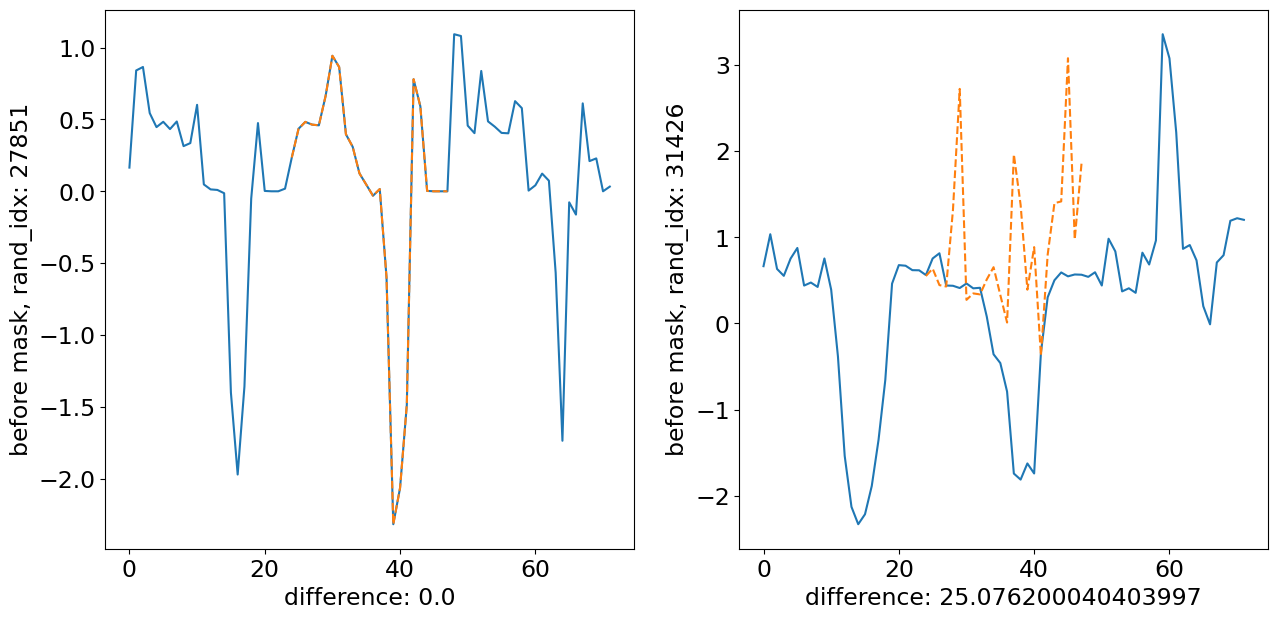

In [50]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_vec) * masking_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2)
rand_idx1 = np.random.randint(0, len(net_consumption_vec) - 48 - mask_len)
predicted = predict_next_day_masked(net_consumption_vec[rand_idx1:rand_idx1 + 24], masking_ratio)
ax1.plot(net_consumption_vec[rand_idx1:rand_idx1 + 72], label="Input")
ax1.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax1.set_ylabel(f"before mask, rand_idx: {rand_idx1}")
ax1.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx1+24:rand_idx1+48]))}")

rand_idx2 = np.random.randint(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48)
predicted = predict_next_day_masked(net_consumption_vec[rand_idx2:rand_idx2 + 24], masking_ratio)
ax2.plot(net_consumption_vec[rand_idx2:rand_idx2 + 72], label="Input")
ax2.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax2.set_ylabel(f"before mask, rand_idx: {rand_idx2}")
ax2.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx2+24:rand_idx2+48]))}")

plt.show()

## Intermediate summary
This is nice but not very good. We can see that the prediction is not very accurate. We can try to improve the prediction by using a more complex model, such as LSTM or even simple convNet.

Anyway, the function which we can use for now is:

In [51]:
def predict_next_day(input_vec: np.ndarray) -> np.ndarray:
    """
    Predict the next 4 hours consumption from the previous 4 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
    """

    weights = np.append(np.array([0, 0.25, 0.5, 0.75]), np.ones(20))

    prediction_24 = predict_next_24h(input_vec)
    prediction_4 = np.append(predict_next_4h(input_vec[-4:]), np.zeros(20))

    return prediction_24 * weights + prediction_4 * (1 - weights)

## Prediction certainty
We can keep to the 24hrs only and extract the certainty of the prediction from the correlation between the input and the best fitted sequence.
For this, we will use an additional function:

In [52]:
def predict_next_24h_masked_with_certainty(input_vec: np.ndarray, ratio: float) -> (np.ndarray, float):
    """
    Predict the next day consumption from the previous 24 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    assert len(input_vec) == 24, "The input vector must be of length 24"

    input_vec = input_vec / np.sqrt(sum(input_vec ** 2))

    net_consumption = np.load('data/net_consumption_24.npy')
    norm_vec = np.load('data/net_consumption_norm24.npy')

    mask_length = int(len(net_consumption) * ratio)
    net_consumption = net_consumption[:-mask_length]
    norm_vec = norm_vec[:-mask_length]

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+24]) for i in range(len(net_consumption)-47)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+24:idx_from_correlation+48]

    return prediction, correlation[idx_from_correlation]

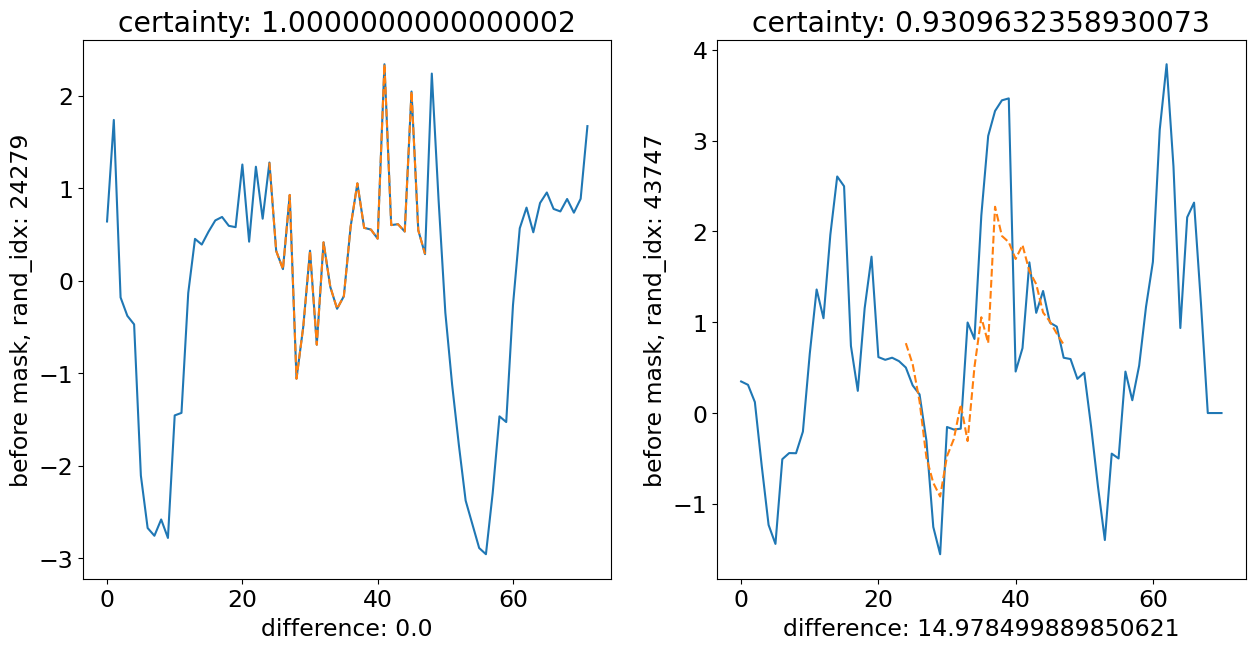

In [53]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_vec) * masking_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2)
rand_idx1 = np.random.randint(0, len(net_consumption_vec) - 48 - mask_len)
predicted, certainty = predict_next_24h_masked_with_certainty(net_consumption_vec[rand_idx1:rand_idx1 + 24], masking_ratio)
ax1.plot(net_consumption_vec[rand_idx1:rand_idx1 + 72], label="Input")
ax1.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax1.set_ylabel(f"before mask, rand_idx: {rand_idx1}")
ax1.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx1+24:rand_idx1+48]))}")
ax1.set_title(f"certainty: {certainty}")

rand_idx2 = np.random.randint(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48)
predicted, certainty = predict_next_24h_masked_with_certainty(net_consumption_vec[rand_idx2:rand_idx2 + 24], masking_ratio)
ax2.plot(net_consumption_vec[rand_idx2:rand_idx2 + 72], label="Input")
ax2.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax2.set_ylabel(f"before mask, rand_idx: {rand_idx2}")
ax2.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_vec[rand_idx2+24:rand_idx2+48]))}")
ax2.set_title(f"certainty: {certainty}")

plt.show()

We can now plot the certainty before and after the masked area:

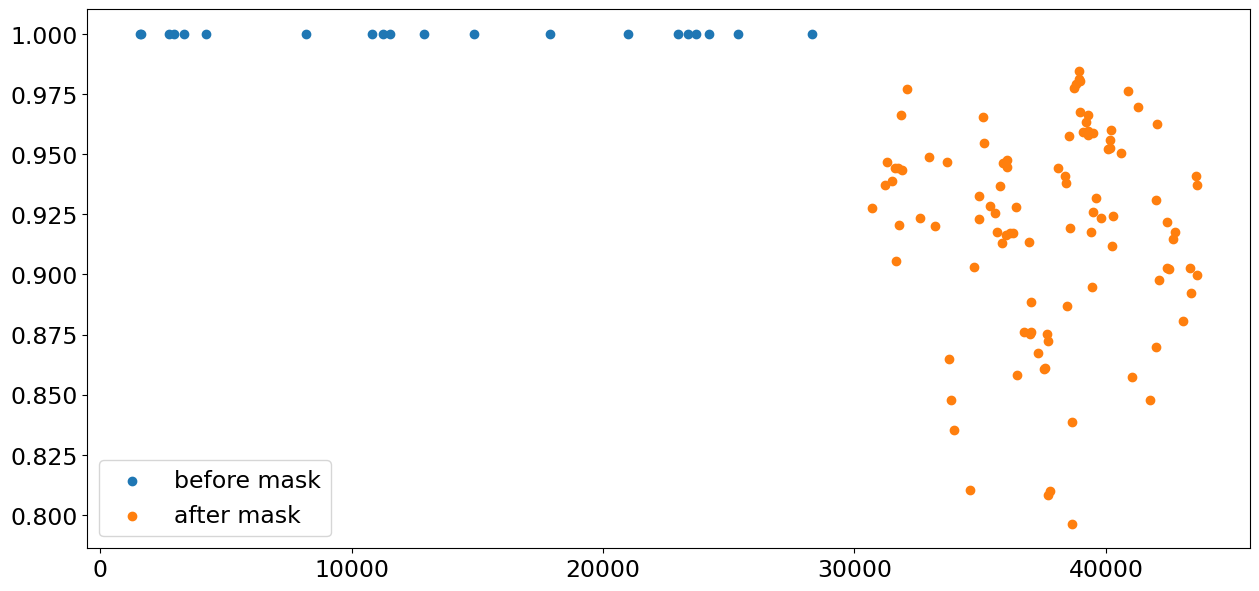

In [54]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_vec) * masking_ratio)

idx_pre = np.random.randint(0, len(net_consumption_vec) - 48 - mask_len, 20)
idx_post = np.random.randint(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48, 100)
certainty_pre = np.zeros_like(idx_pre, dtype=float)
certainty_post = np.zeros_like(idx_post, dtype=float)

for count, idx in enumerate(idx_pre):
    _, certainty_pre[count] = predict_next_24h_masked_with_certainty(net_consumption_vec[idx:idx+24], masking_ratio)

for count, idx in enumerate(idx_post):
    _, certainty_post[count] = predict_next_24h_masked_with_certainty(net_consumption_vec[idx:idx+24], masking_ratio)

plt.figure()
plt.scatter(idx_pre, certainty_pre, label="before mask")
plt.scatter(idx_post, certainty_post, label="after mask")
plt.legend()
plt.show()

We see that before the masked area the prediction is perfect, but after the masked area the prediction certinaty is <1, as expected.

The question now is wheter we can use this certainty to predict the prediction error.
For this we shall first define it.

## Prediction error

To capture the importance of the first prediction, we will introduce a weighting function.
We want to have high weight for the first prediction and low weight for the last prediction. We heuristically choose an exponent  function for this:

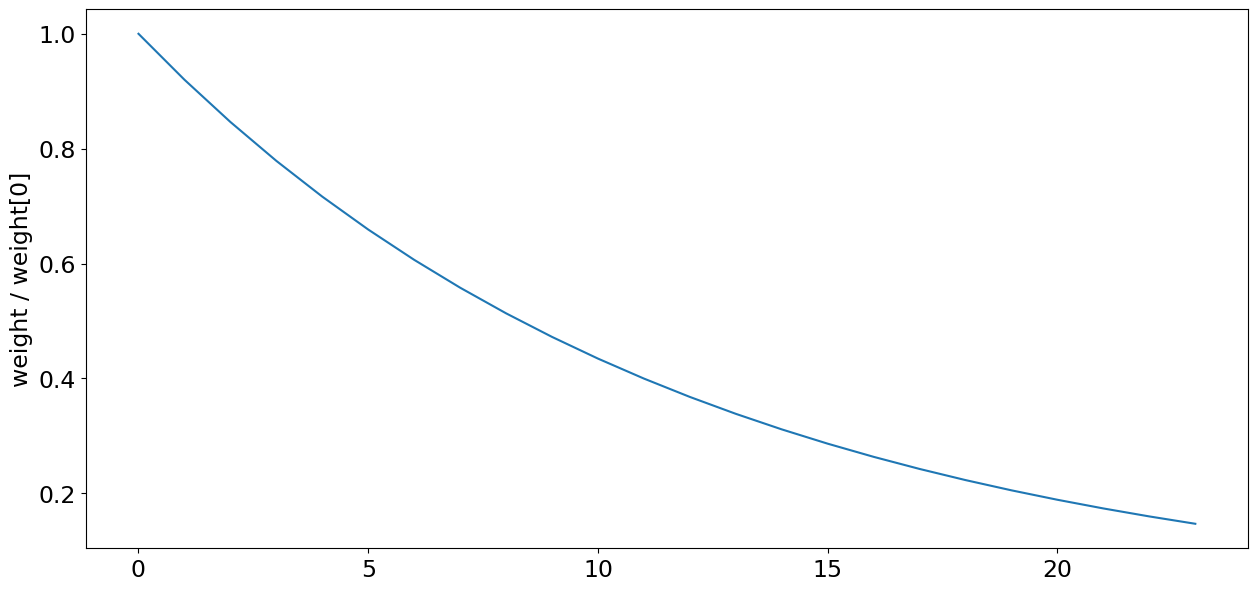

In [55]:
weights_for_loss = np.exp( - np.arange(0, 24) / 12) / sum(np.exp( - np.arange(0, 24) / 12))
plt.figure()
plt.plot(weights_for_loss / weights_for_loss[0])
plt.ylabel("weight / weight[0]")
plt.show()

Now we can define few prediction errors:
- The weighted prediction error, which is the sum of the absolute difference (MAE) between the prediction and the real value, weighted by the weights defined above and normalized by the prediction and ground truth norms.
- RMSE, which is the root mean squared error between the prediction and the real value, with weighting and normalization.
- Dot product, with weighting. We will use $\sqrt(1-z^2)$ to translate the cosine distance to a sine one, so 0 would be perfect prediction and 1 would be the worst prediction.

We also define the uncertainty as 1 - certainty.

### Beware! a long calculation ahead! The results are saved in a csv file, so you can load them from 'data/pre_mask.csv', 'data/post_mask.csv' and skip this cell.

In [56]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_vec) * masking_ratio)

idx_pre = np.random.randint(0, len(net_consumption_vec) - 48 - mask_len - 24, 32)
# idx_post = np.random.randint(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48, 100)
idx_post = np.arange(len(net_consumption_vec) - mask_len + 24, len(net_consumption_vec) - 48)
certainty_pre = np.zeros_like(idx_pre, dtype=float)
certainty_post = np.zeros_like(idx_post, dtype=float)

weights_for_loss = np.exp( - np.arange(0, 24) / 12) / sum(np.exp( - np.arange(0, 24) / 12))
mae_pre_24 = np.zeros_like(idx_pre, dtype=float)
mae_post_24 = np.zeros_like(idx_post, dtype=float)
rmse_pre_24 = np.zeros_like(idx_pre, dtype=float)
rmse_post_24 = np.zeros_like(idx_post, dtype=float)
mdpe_pre_24 = np.zeros_like(idx_pre, dtype=float)
mdpe_post_24 = np.zeros_like(idx_post, dtype=float)
mae_pre_combined = np.zeros_like(idx_pre, dtype=float)
mae_post_combined = np.zeros_like(idx_post, dtype=float)
rmse_pre_combined = np.zeros_like(idx_pre, dtype=float)
rmse_post_combined = np.zeros_like(idx_post, dtype=float)
mdpe_pre_combined = np.zeros_like(idx_pre, dtype=float)
mdpe_post_combined = np.zeros_like(idx_post, dtype=float)

for count, idx in enumerate(idx_pre):
    prediction, certainty_pre[count] = predict_next_24h_masked_with_certainty(net_consumption_vec[idx:idx+24], masking_ratio)
    mae_pre_24[count] = sum(abs(prediction - net_consumption_vec[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))
    rmse_pre_24[count] = np.sqrt(sum((prediction - net_consumption_vec[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_pre_24[count] = sum(prediction * net_consumption_vec[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))

    prediction = predict_next_day_masked(net_consumption_vec[idx:idx+24], masking_ratio)
    mae_pre_combined[count] = sum(abs(prediction - net_consumption_vec[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))
    rmse_pre_combined[count] = np.sqrt(sum((prediction - net_consumption_vec[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_pre_combined[count] = sum(prediction * net_consumption_vec[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))

mdpe_pre_24 = np.sqrt(1 - mdpe_pre_24 ** 2)
mdpe_pre_combined = np.sqrt(1 - mdpe_pre_combined ** 2)
uncertainty_pre = 1 - certainty_pre

for count, idx in enumerate(idx_post):
    prediction, certainty_post[count] = predict_next_24h_masked_with_certainty(net_consumption_vec[idx:idx+24], masking_ratio)
    mae_post_24[count] = sum(abs(prediction - net_consumption_vec[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(abs(prediction) * weights_for_loss) + sum(abs(net_consumption_vec[idx+24:idx+48]) * weights_for_loss))
    rmse_post_24[count] = np.sqrt(sum((prediction - net_consumption_vec[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) + sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_post_24[count] = sum(prediction * net_consumption_vec[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))

    prediction = predict_next_day_masked(net_consumption_vec[idx:idx+24], masking_ratio)
    mae_post_combined[count] = sum(abs(prediction - net_consumption_vec[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(abs(prediction) * weights_for_loss) + sum(abs(net_consumption_vec[idx+24:idx+48]) * weights_for_loss))
    rmse_post_combined[count] = np.sqrt(sum((prediction - net_consumption_vec[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) + sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_post_combined[count] = sum(prediction * net_consumption_vec[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_vec[idx+24:idx+48] ** 2 * weights_for_loss))

mdpe_post_24 = np.sqrt(1 - mdpe_post_24 ** 2)
mdpe_post_combined = np.sqrt(1 - mdpe_post_combined ** 2)
uncertainty_post = 1 - certainty_post

The cell above calculated all possible loss for both combined and 24h prediction. Now we can plot the losses to see the relation to the certainty.
First, we compare the combined vs. 24 hours only predictions:

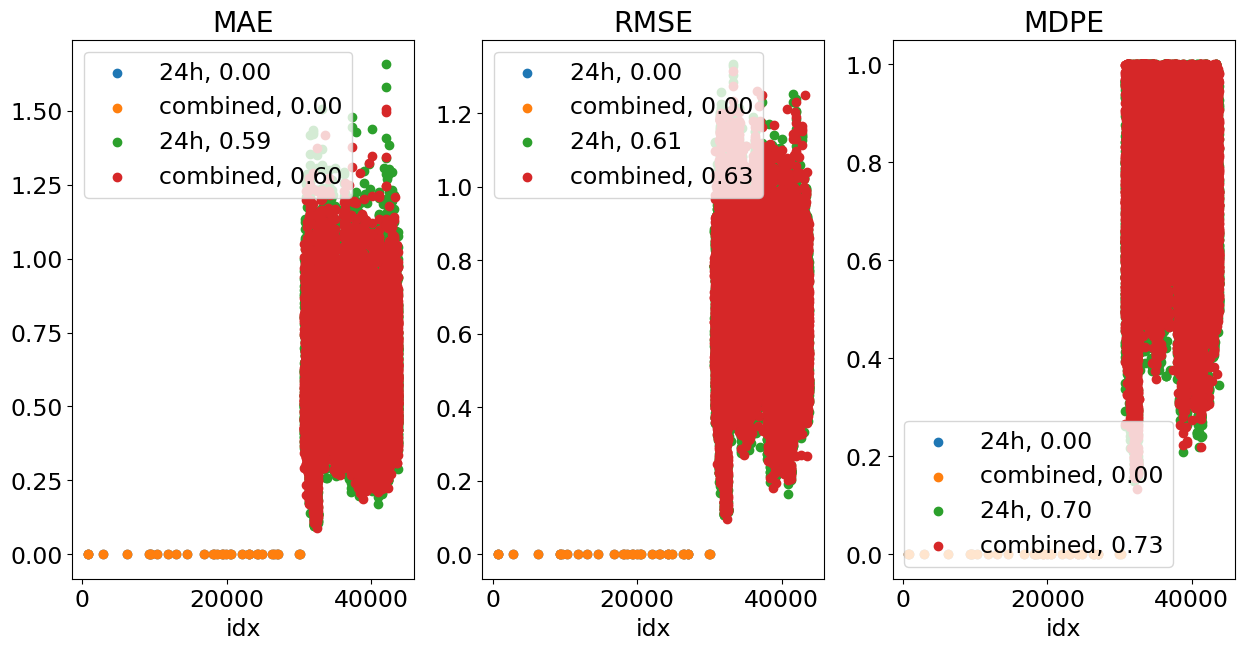

In [57]:
_, axs = plt.subplots(1, 3)

axs[0].scatter(idx_pre, mae_pre_24, label=f"24h, {np.mean(mae_pre_24):.2f}")
axs[0].scatter(idx_pre, mae_pre_combined, label=f"combined, {np.mean(mae_pre_combined):.2f}")
axs[0].scatter(idx_post, mae_post_24, label=f"24h, {np.mean(mae_post_24):.2f}")
axs[0].scatter(idx_post, mae_post_combined, label=f"combined, {np.mean(mae_post_combined):.2f}")
axs[0].set_xlabel("idx")
axs[0].set_title("MAE")
axs[0].legend()

axs[1].scatter(idx_pre, rmse_pre_24, label=f"24h, {np.mean(rmse_pre_24):.2f}")
axs[1].scatter(idx_pre, rmse_pre_combined, label=f"combined, {np.mean(rmse_pre_combined):.2f}")
axs[1].scatter(idx_post, rmse_post_24, label=f"24h, {np.mean(rmse_post_24):.2f}")
axs[1].scatter(idx_post, rmse_post_combined, label=f"combined, {np.mean(rmse_post_combined):.2f}")
axs[1].set_xlabel("idx")
axs[1].set_title("RMSE")
axs[1].legend()

axs[2].scatter(idx_pre, mdpe_pre_24, label=f"24h, {np.mean(mdpe_pre_24):.2f}")
axs[2].scatter(idx_pre, mdpe_pre_combined, label=f"combined, {np.mean(mdpe_pre_combined):.2f}")
axs[2].scatter(idx_post, mdpe_post_24, label=f"24h, {np.mean(mdpe_post_24):.2f}")
axs[2].scatter(idx_post, mdpe_post_combined, label=f"combined, {np.mean(mdpe_post_combined):.2f}")
axs[2].set_xlabel("idx")
axs[2].set_title("MDPE")
axs[2].legend()

plt.show()

Already from these we see that we don't get any gain from the combined prediction, so we dich it and focus on the 24h prediction.
What we will now interest in is the losses vs. the uncertinaty.

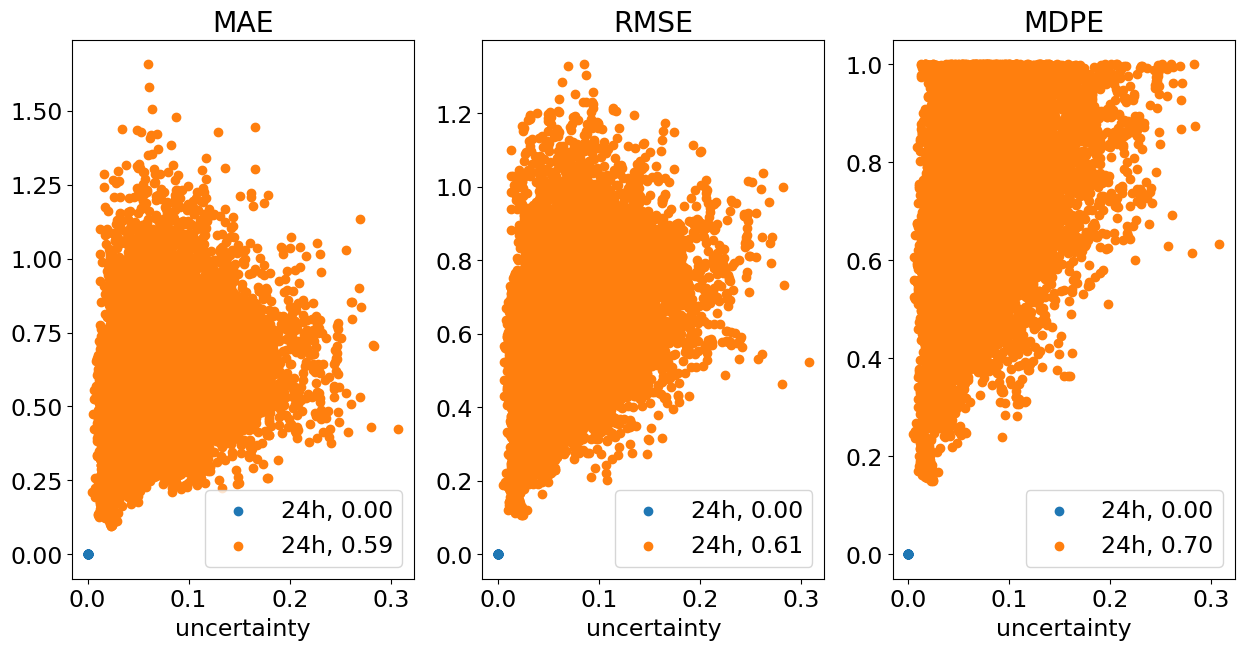

In [58]:
_, axs = plt.subplots(1, 3)

axs[0].scatter(uncertainty_pre, mae_pre_24, label=f"24h, {np.mean(mae_pre_24):.2f}")
axs[0].scatter(uncertainty_post, mae_post_24, label=f"24h, {np.mean(mae_post_24):.2f}")
axs[0].set_xlabel("uncertainty")
axs[0].set_title("MAE")
axs[0].legend()

axs[1].scatter(uncertainty_pre, rmse_pre_24, label=f"24h, {np.mean(rmse_pre_24):.2f}")
axs[1].scatter(uncertainty_post, rmse_post_24, label=f"24h, {np.mean(rmse_post_24):.2f}")
axs[1].set_xlabel("uncertainty")
axs[1].set_title("RMSE")
axs[1].legend()

axs[2].scatter(uncertainty_pre, mdpe_pre_24, label=f"24h, {np.mean(mdpe_pre_24):.2f}")
axs[2].scatter(uncertainty_post, mdpe_post_24, label=f"24h, {np.mean(mdpe_post_24):.2f}")
axs[2].set_xlabel("uncertainty")
axs[2].set_title("MDPE")
axs[2].legend()

plt.show()

We do find some correlation between the losses and the certainty, but it is not very strong. In particular, we never get a loss <10% if the uncertinaty is not 0. Specifically,

In [72]:
print(f"mininal uncertainty for post mask: {np.min(uncertainty_post)}")
print(f"machine epsilon: {np.finfo(float).eps}")
print("")

print(f"mininal MAE for post mask: {np.min(mae_post_24)}")
print(f"mininal RMSE for post mask: {np.min(rmse_post_24)}")
print(f"mininal MDPE for post mask: {np.min(mdpe_post_24)}")
print("")

print(f"maximal uncertainty for pre mask: {np.max(uncertainty_pre)}")


mininal uncertainty for post mask: 0.004600961474106602
machine epsilon: 2.220446049250313e-16

mininal MAE for post mask: 0.09629225524071248
mininal RMSE for post mask: 0.10685947934617991
mininal MDPE for post mask: 0.14997068157055196

maximal uncertainty for pre mask: 3.3306690738754696e-16


## Conclusion
At least the mininal uncertinaty for the post mask is quite high, so we can use this as a threshold (say 10*np.finfo(float).eps) to filter out the predictions with low certainty. The rest should be predicted with some conv net, assuming we can get validation loss <10%.

Also remember that we can use the 24hrs prediction, the 4 hours addition is redundant.

In [ ]:
# mae_max_slope = (mae_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).max()
# mae_min_slope = (mae_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).min()
# rmse_max_slope = (rmse_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).max()
# rmse_min_slope = (rmse_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).min()
# mdpe_max_slope = (mdpe_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).max()
# mdpe_min_slope = (mdpe_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).min()
#
# _, axs = plt.subplots(1, 3)
#
# axs[0].scatter(uncertainty_pre, mae_pre_24, label=f"24h, {np.mean(mae_pre_24):.2f}")
# axs[0].scatter(uncertainty_post, mae_post_24, label=f"24h, {np.mean(mae_post_24):.2f}")
# axs[0].set_xlabel("uncertainty")
# axs[0].set_title("MAE")
# axs[0].plot([0, min(mae_max_slope * 0.5, 1) / mae_max_slope], [0, min(mae_max_slope * 0.5, 1)], label=f"max slope, {mae_max_slope:.2f}", linestyle="--")
# axs[0].plot([0, 0.5], [0, mae_min_slope * 0.5], label=f"min slope, {mae_min_slope:.2f}", linestyle="--")
# axs[0].legend()
#
# axs[1].scatter(uncertainty_pre, rmse_pre_24, label=f"24h, {np.mean(rmse_pre_24):.2f}")
# axs[1].scatter(uncertainty_post, rmse_post_24, label=f"24h, {np.mean(rmse_post_24):.2f}")
# axs[1].set_xlabel("uncertainty")
# axs[1].set_title("RMSE")
# axs[1].plot([0, min(rmse_max_slope * 0.5, 1) / rmse_max_slope], [0, min(rmse_max_slope * 0.5, 1)], label=f"max slope, {rmse_max_slope:.2f}", linestyle="--")
# axs[1].plot([0, 0.5], [0, rmse_min_slope * 0.5], label=f"min slope, {rmse_min_slope:.2f}", linestyle="--")
# axs[1].legend()
#
# axs[2].scatter(uncertainty_pre, mdpe_pre_24, label=f"24h, {np.mean(mdpe_pre_24):.2f}")
# axs[2].scatter(uncertainty_post, mdpe_post_24, label=f"24h, {np.mean(mdpe_post_24):.2f}")
# axs[2].set_xlabel("uncertainty")
# axs[2].set_title("MDPE")
# axs[2].plot([0, min(mdpe_max_slope * 0.5, 1) / mdpe_max_slope], [0, min(mdpe_max_slope * 0.5, 1)], label=f"max slope, {mdpe_max_slope:.2f}", linestyle="--")
# axs[2].plot([0, 0.5], [0, mdpe_min_slope * 0.5], label=f"min slope, {mdpe_min_slope:.2f}", linestyle="--")
# axs[2].legend()
#
# plt.show()

In [67]:
# pd.DataFrame(np.array([uncertainty_post, certainty_post, mae_post_24, rmse_post_24, mdpe_post_24, mae_post_combined, rmse_post_combined, mdpe_post_combined]).T, columns=['uncertainty', 'certainty', 'mae_24', 'rmse_24', 'mdpe_24', 'mae_combined', 'rmse_combined', 'mdpe_combined']).to_csv("data/post_mask.csv")